# One-dimensional bandwidth sweep

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.scipy.stats import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from svgd import SVGD, get_bandwidth
from utils import dict_concatenate, dict_mean
from tqdm import tqdm

In [2]:
n=100
d=1
stepsize = 0.01
L = 100 # 100 slightly to little, this should be all right
grid_length = 25

from utils import log_gaussian_mixture
logp = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])

svgd_fix = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))
bandwidth_grid = np.logspace(-10, 15, num=grid_length, base=2)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWar

In [3]:
from metrics import get_metrics, metric_names

def sweep(rkey, grid):
    """Sweep a grid of bandwidth values and output corresponding metrics."""
    sweep_results = []
    for h in tqdm(grid):
        xout, _ = svgd_fix.svgd(rkey, stepsize, h, L)
        sweep_results.append(get_metrics(xout, logp))
    return np.array(sweep_results)

In [4]:
m = 15
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)

  0%|          | 0/25 [00:00<?, ?it/s]

JIT COMPILING...
Done compiling in 0.6953153610229492 seconds.


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Then get the same metrics for the adaptive bandwidth:

In [5]:
adas = []
for _ in range(m):
    svgd_ada.newkey()
    xout, _ = svgd_ada.svgd(svgd_ada.rkey, stepsize, 0, L)
    metrics_ada = get_metrics(xout, logp)
    adas.append(metrics_ada)
adas = np.array(adas)
metrics_ada = np.mean(adas, axis=0)

JIT COMPILING...
Done compiling in 0.6089825630187988 seconds.


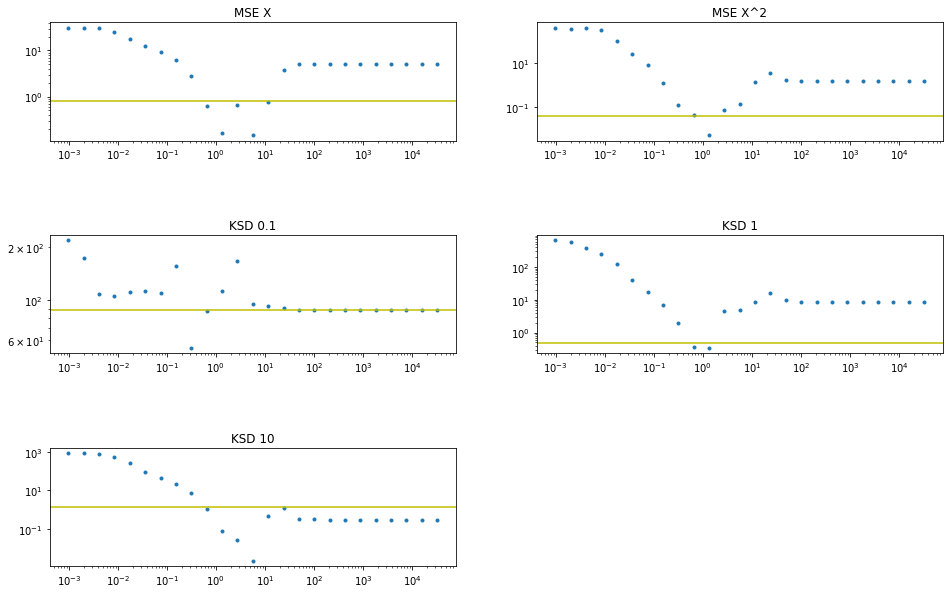

In [6]:
plt.figure(1, figsize=[16.0, 10.0])
plt.subplots_adjust(hspace=0.8)
col = plt.rcParams['axes.prop_cycle'].by_key()['color']
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    plt.plot(bandwidth_grid, sw, ".", col[i])
    plt.xscale('log')
    plt.yscale('log')
    
    plt.axhline(y=float(metrics_ada[i]), color="y")

# Two-dimensional bandwidth sweep

In [7]:
n=100
d=2
stepsize = 0.01
L = 300
grid_length = 25

In [8]:
bandwidth_grid = np.logspace(-3, 5, num=grid_length)
# bandwidth_grid = np.reshape(bandwidth_grid, (grid_length, 1))
bandwidth_grid = np.tile(bandwidth_grid, (d, 1))
bandwidth_grid = np.transpose(bandwidth_grid)
bandwidth_grid.shape

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


(25, 2)

In [9]:
from jax.scipy.stats import norm

@jit
def logp(x):
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

svgd_fix = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [10]:
from metrics import ksd
metric_names = ["MSE X", "MSE X^2", "KSD 0.1", "KSD 1", "KSD 10"]
def get_metrics(xout, logp):
    """
    Compute metrics.
    """
    assert xout.ndim == 2
    assert xout.shape[1] == 2
    assert not np.any(np.isnan(xout))

    metrics = []
    # MSEs
    metrics.append(np.mean((np.mean(xout, axis=0) - 0)**2))
    metrics.append(np.mean((np.mean(xout**2, axis=0) - 1)**2))
    
    #KSDs
    for ksd_bandwidth in [0.1, 1, 10]:
        metrics.append(ksd(xout, logp, ksd_bandwidth))
    return metrics

In [11]:
m = 3
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)

  0%|          | 0/25 [00:00<?, ?it/s]

JIT COMPILING...
Done compiling in 0.4754037857055664 seconds.


100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


In [ ]:
np.any(np.isnan(sweeps))

In [12]:
adas = []
for _ in range(m):
    svgd_ada.newkey()
    xout, _ = svgd_ada.svgd(svgd_ada.rkey, stepsize, 0, L)
    metrics_ada = get_metrics(xout, logp)
    adas.append(metrics_ada)
adas = np.array(adas)
metrics_ada = np.mean(adas, axis=0)

JIT COMPILING...
Done compiling in 0.4367997646331787 seconds.


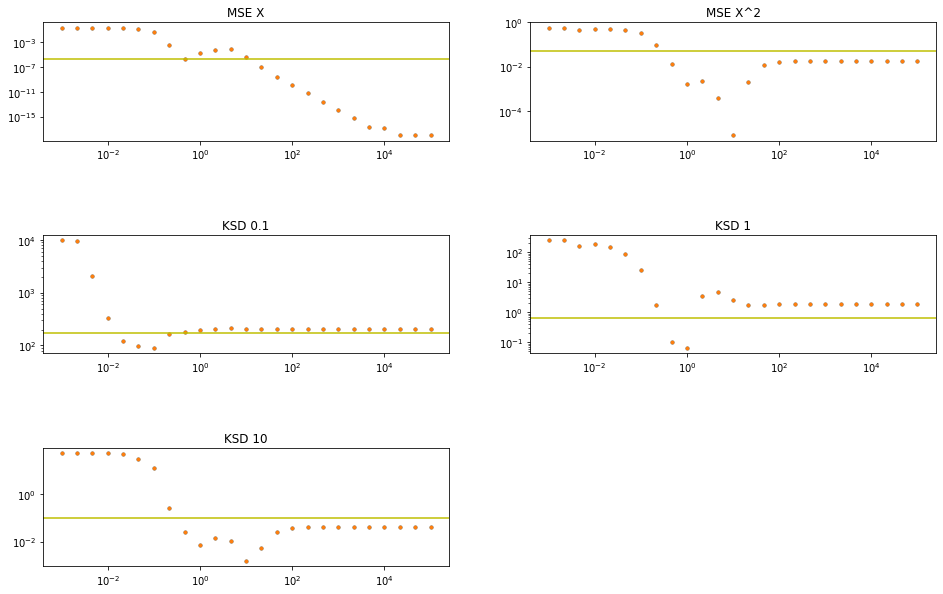

In [13]:
plt.figure(1, figsize=[16.0, 10.0])
plt.subplots_adjust(hspace=0.8)
col = plt.rcParams['axes.prop_cycle'].by_key()['color']
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    plt.plot(bandwidth_grid, sw, ".", col[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.axhline(y=float(metrics_ada[i]), color="y")

## Random grid search

In [14]:
grid_length = 100
rkey = random.PRNGKey(123)
bandwidth_grid = random.uniform(rkey, shape=(grid_length, d)) * 25 - 10
bandwidth_grid = 2**bandwidth_grid

In [15]:
m = 3
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)

100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


### Scatterplot

In [16]:
def scatter(grid, data):
#     plt.figure(1, figsize=[8, 8])
    x, y = grid.transpose()
    colors = data
    colors = np.log(colors)

    plt.scatter(x, y, s=100, c=colors)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("h1")
    plt.ylabel("h2")

    for i, v in enumerate(data):
        if i % 5 == 0:
            plt.annotate(v, (x[i], y[i]))

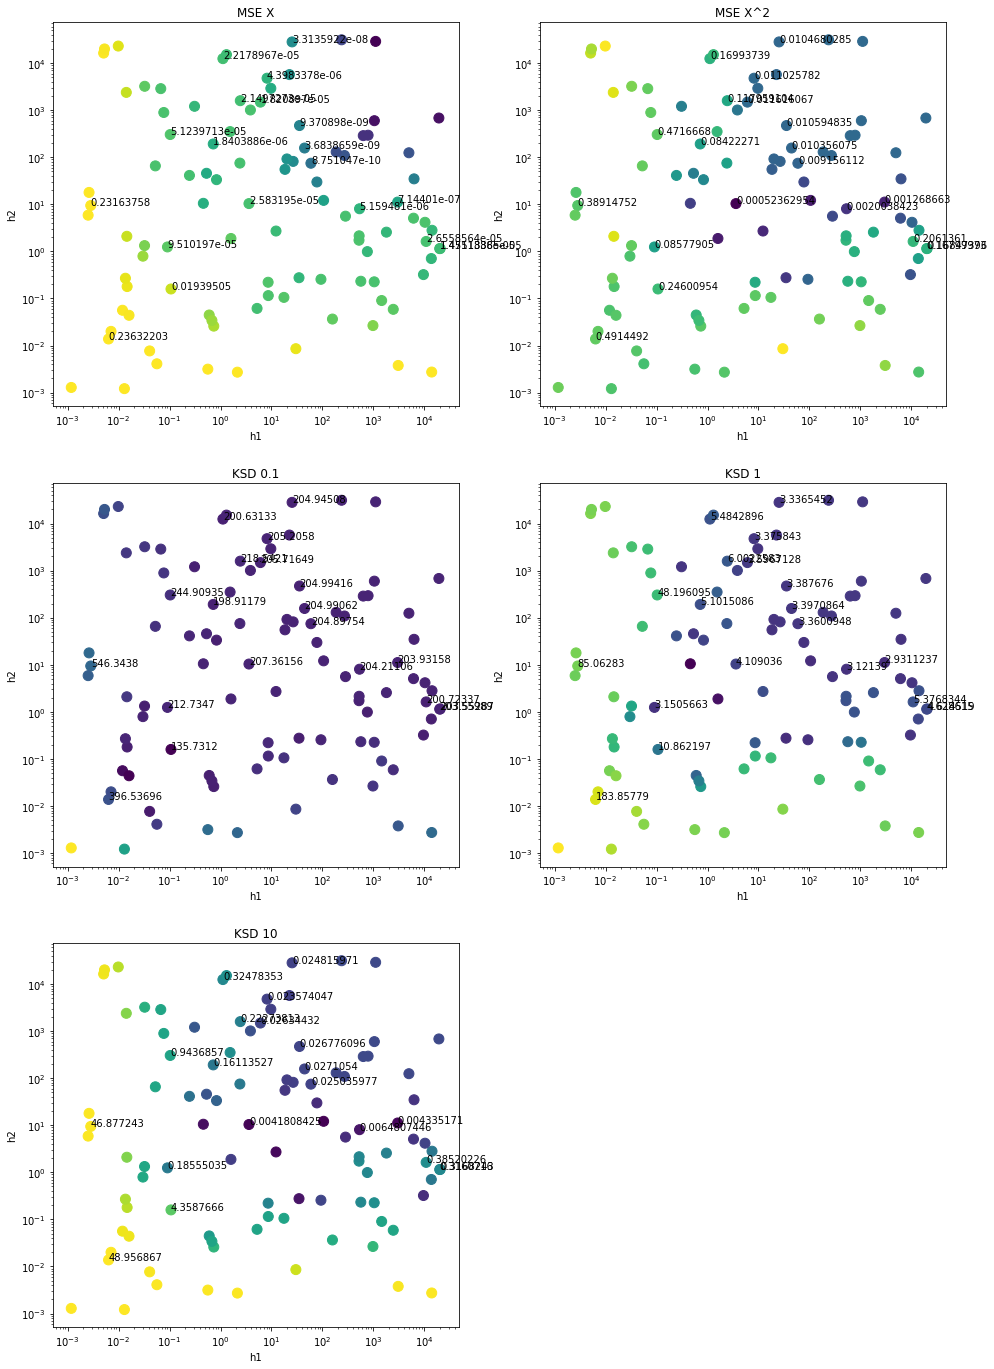

In [23]:
plt.figure(1, figsize=[16.0, 24.0])
# plt.subplots_adjust(hspace=0.8)
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    scatter(bandwidth_grid, sweeps[i])
# scatter(bandwidth_grid, sweeps[2])
# plt.title(metric_names[2])